<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


This workshop is worth 25% of the total module mark.





Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [1]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np
from time import time

%config InlineBackend.figure_format = 'svg'

# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [2]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discoount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        for c in range(width): 
            for r in range(height): 
                if [c,r] == goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        #pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            #pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv)
            
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )

print('GridWorld state indexing:')
print(world.grid)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 3.  2.  2.  2.  2.  1.]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [3]:
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
# print(world.tostring())
np.set_printoptions(precision=2)
# world.show_states()
# print('Initial value function:')
V = np.zeros(len(world.states))
# print(V.reshape((world.width,world.height)).T)


# a.

vfs = []

n = len(world.states)
p = 1 / len(world.actions)
delta = 1

# Repeat 
while delta > 1e-5:

    # New value function.
    Vn = np.zeros(n)
    
    delta = 0

    # Loop over state space.
    for s in range(n):
        
        if s == world.goal:
            continue
        
        # Retrieve state transition values.
        sv, rv = world.state_transition(s)
        
        # Update new value function with result of bellman equation.
        Vn[s] = sum([p * (r + world.gamma * V[ns]) for ns, r in zip(sv, rv)])
        
        # Check whether improvement has been made.
        delta = max(delta, abs(Vn[s] - V[s])) 
    
    # Update value function V.
    V = Vn
    
    # Record value function at time t.
    vfs += [Vn]


# b.
   
# Print out specific iterations.
for i in [1, 2, 5, 10]:
    print('Iteration {}'.format(i))
    print(vfs[i-1].reshape(5,5))
    print()
    
    
# c.


solution = []
Vpi = vfs[-1]
x = world.start

while x != world.goal:

    sv, rv = world.state_transition(x)
    nextOptions = [(Vpi[ns], ns) for ns in sv]
    value, x = max(nextOptions, key=lambda x : x[0])
    
    solution += [x]

print(world.print_solution(solution))

Iteration 1
[[-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -0.75]
 [-1.   -1.   -1.   -0.75  0.  ]]

Iteration 2
[[-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.84]
 [-1.9  -1.9  -1.9  -1.79 -1.37]
 [-1.9  -1.9  -1.84 -1.37  0.  ]]

Iteration 5
[[-4.1  -4.1  -4.1  -4.09 -4.09]
 [-4.1  -4.1  -4.09 -4.07 -4.03]
 [-4.1  -4.09 -4.06 -3.95 -3.76]
 [-4.09 -4.07 -3.95 -3.55 -2.68]
 [-4.09 -4.03 -3.76 -2.68  0.  ]]

Iteration 10
[[-6.51 -6.5  -6.48 -6.45 -6.42]
 [-6.5  -6.48 -6.43 -6.34 -6.25]
 [-6.48 -6.43 -6.29 -6.02 -5.66]
 [-6.45 -6.34 -6.02 -5.24 -3.92]
 [-6.42 -6.25 -5.66 -3.92  0.  ]]

Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*|G|
+-+-+-+-+-+



The output shows the value function after certain iterations as specified by the question. My code works as expected, I have reshaped the array to align to the original grid world problem. I then calculated the solution using a greedy strategy and used the World's method to print out the solution on the grid world problem.

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:

a. Implement the SARSA algorithm, using an $\epsilon$-greedy policy. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>


In [4]:
# a.

def eps(Q, state, epsilon):
    if np.random.uniform() > epsilon:
        # Select the action with max value.
        return np.argmax(Q[state,:])
    else:
        # Explore, select a random action
        return np.random.choice(range(4))


def sarsa(world, alpha, epsilon, gamma, episodes=100, printSolution=False, storeBest=True):
    
    # Initialise variables.
    Q = np.zeros((len(world.states), len(world.actions)))
    best = float('-inf')
    np.random.seed(0)
    rewardTotal = []
    solution = []

    # Train Q.
    for i in range(episodes):
        
        # Initialise episode.
        path = []
        reward = 0
        s = world.start
        a = eps(Q, s, epsilon)
        
        while True:
            
            # Find next state and reward.
            sv, rv = world.state_transition(s)
            r = rv[a]
            s_ = sv[a]
            
            # Generate next action.
            a_ = eps(Q, sv[a], epsilon)
            
            # Update reward for episode.
            reward += r
            
            # Add state to path.
            path += [s_]
            
            # If goal node has been reached.
            if s_ == world.goal:
                
                # Update Q matrix.
                Q[s, a] += alpha * (r - Q[s, a])
                
                # Append reward.
                rewardTotal += [reward]
                
                # Replace if solution is better.
                if storeBest:
                    if reward > best:
                        solution = path
                        best = reward
                        
                else:
                    solution = path
                    best = reward
                    
                break
                
            else:
                
                # Update Q matrix.
                Q[s, a] += alpha * (r + (gamma * Q[s_, a_]) - Q[s, a])
                
            # Update state and action.
            s, a = s_, a_
            
    # Print graphical grid solution.
    if printSolution:
        print('Epsilon: {}'.format(epsilon))
        print('Reward: {}'.format(best))
        print(world.print_solution(solution))
            
    return rewardTotal


def drawGraph(world, algo, epsilons):
    
    # Initialise variables.
    alpha = 0.4
    gamma = 0.9
    episodes = 200
    repeat = 100
    
    for e in epsilons:
        
        # Generate results for repeat amount of SARSA results.
        yy = [sarsa(world, alpha, e, gamma, episodes) for _ in range(repeat)]
        
        # Average results.
        y = np.sum(np.array(yy), axis=0) / len(yy)
        
        # X domain.
        x = range(len(y))
        
        # Plot epsilon line.
        plt.plot(x, y, label='$\epsilon = {}$'.format(e))
    
    # Configure graph.
    plt.xlabel('Number of Episodes')
    plt.ylabel('Reward')
    plt.legend(loc='lower right')
    plt.show()
    
def showSolution(world, algo, epsilons, storeBest):
    
    # Initialise variables.
    alpha = 0.4
    gamma = 0.9
    episodes = 200
    repeat = 100
    
    for e in epsilons:
        
        # Print out solution.
        algo(world, alpha, e, gamma, episodes, True, storeBest)

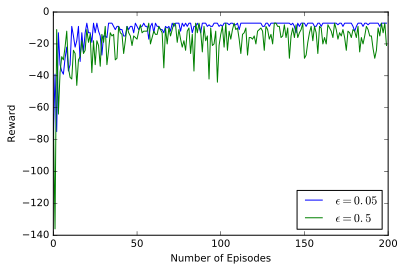

In [5]:
# b

drawGraph(world, sarsa, [0.05, 0.5])

The graph shows that the reward starts off very high but in a short amount of episodes begins to reach lower rewards, this is the same for both values of epsilon I have used. However the difference between them is that the value of 0.05 for epsilon produces a smoother line quicker than the value of 0.5. This is because a small value means it uses the Q matrix to decide most of the time wheras with a value of 0.5 there is a high chance the agent will chose a random action.

In [6]:
# c

showSolution(world, sarsa, [0.05, 0.25, 0.5, 0.75], True)

Epsilon: 0.05
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.25
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*|*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.5
Reward: -7.0
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

Epsilon: 0.75
Reward: -7.0
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



These first set of results show the best solution that was found over the whole episode. They were all able to find the optimal route.

In [7]:
showSolution(world, sarsa, [0.05, 0.25, 0.5, 0.75], False)

Epsilon: 0.05
Reward: -7.0
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.25
Reward: -11.0
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

Epsilon: 0.5
Reward: -21.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
|*|*|*|*|*|
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.75
Reward: -55.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
|*| |*|*|*|
+-+-+-+-+-+
|*|*|*|*|*|
+-+-+-+-+-+
|*|*|*|*|*|
+-+-+-+-+-+
|*|*|*| |G|
+-+-+-+-+-+



This set of results shows the last solution that was achieved by the algorithm. You can see that with smaller values of epsilon the solution is better. This is because epsilon controls whether to pick the best percieved action or a random one. This may lead to more exploration but means individual runs will be more likely to fail in some way or take longer. The solution to this is reducing the value of epsilon as time goes on and the Q matrix is improved because then it will begin using the Q matrix more and get a better result.

## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

a. implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>
c. Finally, show the solution your algorithm has reached for different values of $\epsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

In [8]:
# a.

def qLearning(world, alpha, epsilon, gamma, episodes=100, printSolution=False, storeBest=True):
    
    # Initialise variables.
    Q = np.zeros((len(world.states), len(world.actions)))
    best = float('-inf')
    np.random.seed(0)
    rewardTotal = []
    solution = []

    # Train Q.
    for i in range(episodes):
        
        # Initialise episode.
        path = []
        reward = 0
        s = world.start
        a = eps(Q, s, epsilon)
        
        while True:
            
            # Find next state and reward.
            sv, rv = world.state_transition(s)
            r = rv[a]
            s_ = sv[a]
            
            # Find next action.
            a_ = np.argmax(Q[s_,:])
            
            # Update reward for episode.
            reward += r
            
            # Add state to path.
            path += [s_]
            
            # If goal node has been reached.
            if s_ == world.goal:
                
                # Update Q matrix.
                Q[s, a] += alpha * (r - Q[s, a])
                
                # Append reward.
                rewardTotal += [reward]
                
                # Replace if solution is better.
                if storeBest:
                    if reward > best:
                        solution = path
                        best = reward
                        
                else:
                    solution = path
                    best = reward
                    
                break
                
            else:
                
                # Update Q matrix.
                Q[s, a] += alpha * (r + (gamma * Q[s_, a_]) - Q[s, a])
                
            # Update state and action.
            s, a = s_, a_
            
    # Print graphical grid solution.
    if printSolution:        
        print('Epsilon: {}'.format(epsilon))
        print('Reward: {}'.format(best))
        print(world.print_solution(solution))
            
    return rewardTotal

def comparison(world, storeBest):
    
    # Initialise variables.
    alpha = 0.4
    gamma = 0.9
    epsilon = 0.05
    episodes = 1000
    
    # Print SARSA algorithm.
    print('SARSA Algorithm')
    sarsa(world, alpha, epsilon, gamma, episodes, True, storeBest)
    
    # Print results of Q learning algorithm.
    print('Q Learning Algorithm')
    qLearning(world, alpha, epsilon, gamma, episodes, True, storeBest)
    

def graphComparison(world):

    # Initialise variables.
    alpha = 0.4
    gamma = 0.9
    epsilon = 0.05
    episodes = 50
    repeat = 100

    # Get multiple sets of results.
    yy1 = [sarsa(world, alpha, epsilon, gamma, episodes) for _ in range(repeat)]
    yy2 = [qLearning(world, alpha, epsilon, gamma, episodes) for _ in range(repeat)]
    
    # Average results for each episode number.
    y1 = np.sum(np.array(yy1), axis=0) / len(yy1)
    y2 = np.sum(np.array(yy2), axis=0) / len(yy2)

    # Find x domain.
    x = range(len(y1))

    # Plot SARSA and QLearning results.
    plt.plot(x, y1, label='SARSA Algorithm')
    plt.plot(x, y2, label='Q Learning Algorithm')
    
    # Configure graph.
    plt.xlabel('Number of Episodes')
    plt.ylabel('Reward')
    plt.legend(loc='lower right')
    plt.show()

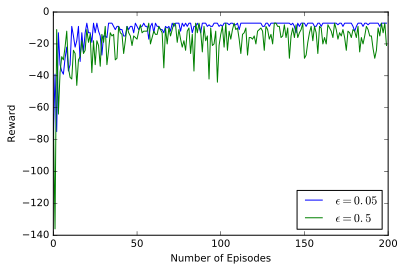

In [9]:
# b.

drawGraph(world, qLearning, [0.05, 0.5])

This graph shows the same as the graph for the SARSA algorithm. A smaller value of epsilon is better here as it leads to less randomness and therefore a higher number of the agents during an episode achieve a better reward performance.

In [10]:
# c.

showSolution(world, qLearning, [0.05, 0.25, 0.5, 0.75], True)

Epsilon: 0.05
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.25
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.5
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.75
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



This was using the best solution achieved when using the qLearning algorithm. For every epsilon value the best reward possible was obtained.

In [11]:
showSolution(world, qLearning, [0.05, 0.25, 0.5, 0.75], False)

Epsilon: 0.05
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

Epsilon: 0.25
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.5
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*| | |
+-+-+-+-+-+
| | |*| | |
+-+-+-+-+-+
| | |*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Epsilon: 0.75
Reward: -7.0
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



Compared the SARSA algorithm the Q Learning algorithm generated a correct solution for every value of epsilon that was used. This is because it is much less reliant on the epsilon value as it is only used at the start of an episode.

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [12]:
cliff = [[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]]
world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=cliff)

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
world2 = GridWorld(10,10, gamma=0.9, start=[9,0], goal=[0,9], cliff=cliff)

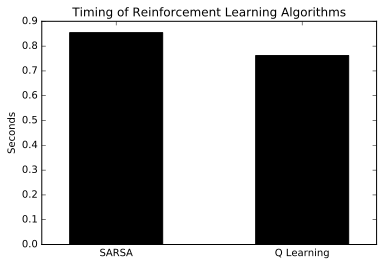

In [13]:
def compareTime(world):
    # Initialise variables.
    alpha = 0.4
    gamma = 0.9
    epsilon = 0.05
    episodes = 100
    
    t1 = time()
    sarsa(world, alpha, epsilon, gamma, episodes)
    t2 = time()
    qLearning(world, alpha, epsilon, gamma, episodes)
    t3 = time()
    
    tSARSA = t2-t1
    tQLearning = t3-t2
    
    plt.bar([0,1], [tSARSA, tQLearning], color='k', align='center', width=0.5)
    plt.xticks([0,1], ('SARSA', 'Q Learning'))
    plt.title('Timing of Reinforcement Learning Algorithms')
    plt.ylabel('Seconds')
    plt.show()
    
compareTime(world1)

In [14]:
comparison(world1, False)

SARSA Algorithm
Epsilon: 0.05
Reward: -29.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| |*|*|*|*| | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|*| |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | |*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*|G|
+-+-+-+-+-+-+-+-+-+-+

Q Learning Algorithm
Epsilon: 0.05
Reward: -23.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | 

In this first comparison I compare the solutions that are last generated by the algorithms. The SARSA algorithm performs fairly well however the solution is not optimal. The Q Learning algorithm gives an optimal solution.

One thing to note is that the SARSA algoritm tends to avoid the cliffs more, whilst it does not seem to be the case for the Q Learning algorithm. This is because the SARSA algorithm is more conservative, which I will discuss at the end.

In [15]:
comparison(world1, True)

SARSA Algorithm
Epsilon: 0.05
Reward: -23.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*| | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*|*|G|
+-+-+-+-+-+-+-+-+-+-+

Q Learning Algorithm
Epsilon: 0.05
Reward: -23.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | |*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | 

In this comparison I have used the best solution from my results and both have achieved the desired solution.

In [16]:
comparison(world2, False)

SARSA Algorithm
Epsilon: 0.05
Reward: -17.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+

Q Learning Algorithm
Epsilon: 0.05
Reward: -17.0
Solution:
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |S|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*| | | | |
+-+-+-+-+-+-+-+-+-+-+
|G|*|*

In this case the SARSA algorithm has learned the optimal solution even without using the best result from all solutions. The Q Learning algorithm also has the optimal solution.

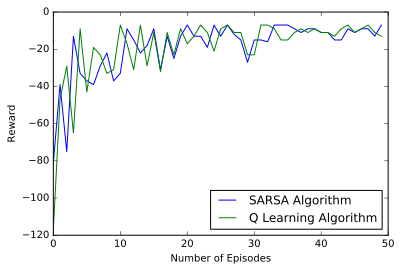

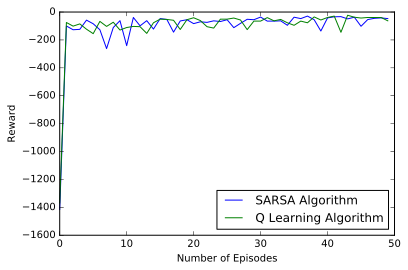

In [17]:
graphComparison(world)
graphComparison(world2)

There is no clear winner when it comes to converging to the optimal solution, however the Q learning algorithm is slightly above the SARSA algorithm especially when looking at the earlier episodes from around 0 to 12.

There are several differences between the SARSA and Q Learning algorithm, the first is that Q Learning directly learns the optimal policy whilst the SARSA algorithm learns a near optimal policy because of the random element with epsilon for deciding on the action. SARSA allows for penalities from exploratory moves, whilst Q learning ignores them. This causes the algorithm to be more conservative. We can see this in our results as the SARSA algorithm has a tendency to stay away from the cliffs whilst the Q learning algorithm gets close to them. This means SARSA is good when you want the agent to avoid certain obstacles such as the cliffs in our problem.